# 최적의 공공자전거 재배치 및 동선 설계

## 개요


**조 분류**: 12조

**조원**: 201904008 곽재원 202104216 백종민

<br>

저희 조는 날씨와 대여 이력 간의 관계, 대여소의 위치와 대여 이력 간의 관계를 통해 "최적의 공공자전거 재배치 및 동선 설계"을 목표로 두고 있습니다.

**목차는 다음과 같습니다.**

1. 분석 목적 및 가설 설정

2. 데이터 불러오기

3. 데이터 전처리

4. 데이터 분석하기

5. 결론 도출

In [14]:
# 전반에 걸쳐 공통적으로 사용되는 라이브러리들을 로드하고 환경 경로에 대한 설정한다.
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# 그래프의 기본 크기 설정
plt.rc("figure", figsize=(12, 6))
plt.rc("font", size=14)

# 경로를 설정하고 해당 작업환경으로 이동한다.
work_dir = '/Users/jaewone/Downloads/공공자전거'
data_path = os.path.join(work_dir, 'data')
location_info_path = os.path.join(data_path, 'locationInfo')
preprocessing_path = os.path.join(data_path, 'preprocessing')
os.chdir(work_dir)

# 폴더가 없을 경우 생성한다.
if not os.path.exists(location_info_path):
    os.mkdir(location_info_path)
if not os.path.exists(preprocessing_path):
    os.mkdir(preprocessing_path)

def csv_iterator(target_path, start_message=None):
    file_list = os.listdir(target_path)
    file_list.sort()
    file_list_length = len(file_list)
    for index in range(len(file_list)):
        file = file_list[index]
        file_path = os.path.join(target_path, file)
        if(start_message != None):
            print(f'[{index + 1}/{file_list_length}] {file} : {start_message}')
        if (os.path.splitext(file_path)[1] == '.csv'):
            yield file_path, index

## 1. 분석 목적 및 가설 설정

"최적의 공공자전거 재배치 및 동선 설계"를 수행하기 위해 다음 사항들을 알아보고자 합니다. 

1. 최적의 재배치 시간은 언제인가.

2. 날씨와 공공자전거 이용률간에 상관관계가 있는가.

3. 최적의 재배치 수량은 몇 개인가.

4. 최적의 재배치 경로는 어떻게 구성할 수 있는가?

## 2. 데이터 불러오기



위 분석 목적 및 가설에 대하여 알아보고자 아래 3개의 데이터 세트를 사용할 것입니다. 

- **서울시 공공자전거 대여 이력**

- **서울시 공공자전거 대여소**

- **종관기상관측(ASOS) 자료**

차례로 각각의 데이터를 불러오겠습니다.


### 2.1 "서울시 공공자전거 대여 이력" 정보 수집



본 데이터 세트의 https://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do 홈페이지에서 CSV 파일을 다운로드 후 사용할 수 있습니다.

가장 최신 6개월의 자료인 2022년 7월 ~ 2022년 12월 공공자전거 대여 이력 정보를 내려받아 받겠습니다.

이를 통해 가져온 CSV는 다음과 같습니다.

> (가져온 CSV는 data/대여이력 폴더 내부에 저장됩니다.)


In [15]:
rent_info = pd.read_csv(
    'data/대여이력/서울특별시 공공자전거 대여이력 정보_2212.csv', encoding='cp949')
rent_info.head(5)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID
0,SPB-44695,2022-12-01 00:00:10,1933,개봉푸르지오아파트 상가,0,2022-12-01 00:00:20,01933,개봉푸르지오아파트 상가,0,0,0.00,\N,M,내국인,ST-678,ST-678
1,SPB-31562,2022-12-01 00:00:04,3007,MBC 앞,0,2022-12-01 00:00:26,03007,MBC 앞,0,0,111.20,1995,F,내국인,ST-2165,ST-2165
2,SPB-56324,2022-12-01 00:01:33,4468,가락1동주민센터,0,2022-12-01 00:01:58,04468,가락1동주민센터,0,0,0.00,1994,M,내국인,ST-2583,ST-2583
3,SPB-30175,2022-12-01 00:03:02,652,답십리 래미안엘파인아파트 입구,0,2022-12-01 00:03:30,00652,답십리 래미안엘파인아파트 입구,0,0,0.00,1981,M,내국인,ST-1447,ST-1447
4,SPB-37639,2022-12-01 00:00:18,1047,강동 한신휴플러스,0,2022-12-01 00:03:55,01075,천동초교 삼거리,0,3,492.34,1989,M,내국인,ST-1369,ST-1836


### 2.2 "서울시 공공자전거 대여소" 정보 수집



> 본 자료는 API 형식으로 제공됨으로 자료를 내려 받아 csv 파일로 변환한 다음 사용하겠습니다.

본 자료에 대한 API는 https://data.seoul.go.kr/dataList/OA-21235/S/1/datasetView.do 을 통해 발급받을 수 있습니다.

위 홈페이지에서 API key를 발급받은 후 http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/1/1000 와 같이 요청하여 사용할 수 있습니다. 이때 마지막 부분의 1/1000에서 1은 시작 페이지 번호이고, 1000은 끝 페이지 번호입니다.

한 번의 요청으로 최대 1,000개의 데이터만 받을 수 있기 때문에
1,000개 단위로 API를 요청하여 정보를 받아온 다음 하나의 CSV 파일로 합쳐주는 작업을 아래 코드를 통해 수행하겠습니다.

> CSV 파일은 data/대여소 정보.csv 라는 파일명으로 저장될 것입니다.


In [16]:
# 서울시 공공자전거 대여소 정보를 가져와 CSV로 저장한다.
from requests import get
from csv import DictWriter

# 데이터의 key값들
keys = ['LENDPLACE_ID', 'STATN_ADDR1', 'STATN_ADDR2', 'STATN_LAT', 'STATN_LNT']
row_list = []

page_count = 1
while (True):
    # 요청 url 설정
    url = f'http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/{(page_count-1)*1000 + 1}/{page_count * 1000}'

    # OpenAPI에 요청
    print("Request: " + url)
    response = get(url)
    response.encoding = 'utf-8'
    dic = response.json()

    # 마지막 페이지일 경우 반복문을 종료한다.
    if (dic.get('bikeStationMaster') == None and dic.get('RESULT').get('CODE') == 'INFO-200'):
        break

    # 알맞은 데이터를 받았는지 확인
    status = dic['bikeStationMaster']['RESULT']['CODE']
    if (status != 'INFO-000'):
        print(f'Error: Status with code {status}')
        exit(1)

    # csv에 저장할 필요한 정보 추출(요청상태와 같이 불필요한 데이터는 csv에 저장하지 않는다)
    data = dic['bikeStationMaster']['row']
    row_list = row_list + data
    page_count = page_count + 1

# 추출된 정보들을 csv 파일로 저장
save_csv_path = 'data/대여소 정보.csv'
with open(save_csv_path, 'w', encoding='UTF-8', newline='') as f:
    print("Saving with csv...")
    w = DictWriter(f, keys)
    w.writeheader()
    w.writerows(row_list)

print(f'Save file: "{save_csv_path}"')

Request: http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/1/1000
Request: http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/1001/2000
Request: http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/2001/3000
Request: http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/3001/4000
Request: http://openapi.seoul.go.kr:8088/786c4b44666a616538385477496f59/json/bikeStationMaster/4001/5000
Saving with csv...
Save file: "data/대여소 정보.csv"


API를 통해 가져온 정보를 확인해 보겠습니다.

In [17]:
location = pd.read_csv('data/대여소 정보.csv', encoding='UTF-8')
location.head(5)

,LENDPLACE_ID,STATN_ADDR1,STATN_ADDR2,STATN_LAT,STATN_LNT
0,ST-10,서울특별시 마포구 양화로 93,427,37.552746,126.918617
1,ST-100,서울특별시 광진구 아차산로 262,더샵스타시티 C동 앞,37.536667,127.073593
2,ST-1000,서울특별시 양천구 신정동 236,서부식자재마트 건너편,37.510380,126.866798
3,ST-1001,서울특별시 양천구 남부순환로4길20,서서울호수공원,0.000000,0.000000
4,ST-1002,서울특별시 양천구 목동동로 316-6,서울시 도로환경관리센터,37.529900,126.876541


### 2.3 "종관기상관측(ASOS)" 자료 수집



본 데이터 세트의 https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1 홈페이지에서 CSV 파일을 내려받은 후 사용할 수 있습니다.

서울시의 2022년 각 날짜에 따른 날씨 데이터로 선택하여 내려받았습니다.

이를 통해 가져온 CSV는 다음과 같습니다.

> (가져온 CSV는 data/seoul_weather.csv 로 저장됩니다.)


In [18]:
weather = pd.read_csv('data/seoul_weather_2022.csv', encoding='cp949')
weather.head(5)

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),안개 계속시간(hr)
0,108,2022-01-01,-4.3,-10.2,710.0,2.3,1544,NaN,NaN,NaN,...,0.9,2.7,6.6,10.1,15.1,17.2,1.3,1.8,0.3,NaN
1,108,2022-01-02,-1.3,-5.2,2356.0,3.0,1551,4.17,NaN,NaN,...,0.8,2.7,6.4,10.0,15.0,17.2,1.1,1.6,NaN,NaN
2,108,2022-01-03,-1.9,-8.0,714.0,2.5,1542,4.00,NaN,NaN,...,0.8,2.5,6.2,9.8,14.9,17.2,1.1,1.6,0.0,NaN
3,108,2022-01-04,-2.5,-5.6,2400.0,1.0,1445,0.92,NaN,NaN,...,0.7,2.5,6.1,9.7,14.8,17.1,1.4,2.0,NaN,NaN
4,108,2022-01-05,-2.8,-7.8,634.0,1.9,1518,NaN,NaN,NaN,...,0.7,2.4,5.9,9.5,14.7,17.1,1.0,1.4,NaN,NaN


## 3. 데이터 전처리



대여소에 대한 데이터와 대여 이력에 대한 정보 모두 상당히 많은 양의 정보를 담고 있으나 **최적의 자전거 재배치 동선 설계**에는 사용되지 않는 **불필요한** 정보들이 포함되어 있습니다. 또한 정제되지 않은 순수 데이터로 Na, 이상치, 등 정확한 데이터 분석을 방해하는 요소들도 많이 있습니다.

본 단계에서는 불필요한 열의 병합 또는 제거, Na값 처리, 이상치 제거, 등의 방법을 통해 데이터를 전처리한 다음 데이터 분석을 수행할 때 바로 활용할 수 있도록 새로운 CSV 파일로 저장할 것입니다.

### 3.1 "서울시 공공자전거 대여 이력 정보" 전처리



"서울시 공공자전거 대여 이력 정보"에 대한 데이터들은 아래 과정을 통해 전처리를 수행하겠습니다.

1. **데이터 분할**
    
    본 데이터셋은 각 이용에 따른 대여 이력 정보와 대여소 정보를 모두 포함하고 있습니다. 
  
    대여 이력 정보를 통해 최적의 재배치 수량 설계 및 동선 설계에 대여소에 대한 정보는 불필요하니 대여소에 대한 정보를 추출하여 별도의 파일로 분리하겠습니다.


2. **사용하지 않는 열 제거**

    본 분석 목적에 부합하지 않는 열은 메모리 낭비를 불러올 수 있어 제거합니다.


3. **이상치 제거**

    이용시간이 0보다 작거나 24시간(1440)보다 큰 값은 명백한 기계 오류, 등에 의해 발생된 이상치입니다. 이상치를 적절히 제거하여 데이터의 품질을 유지합니다.


4. **csv로 저장**

    전처리가 완료된 데이터프레임을 분석을 수행할 때 부로 사용할 수 있도록 csv로 저장해주겠습니다.


5. **각 파일에 적용**

    "서울시 공공자전거 대여 이력 정보"는 7월부터 12월까지 총 6개의 파일로 구성되어 있습니다. 

    이에 반복문을 통해 위 1번부터 4번까지의 과정을 나머지 데이터셋에 대하여 적용하겠습니다.

#### 3.1.1 데이터 분할



open API를 통해 받아온 "대여소 정보"에는 각 대여소에 주소와 위치값은 존재하지만, 대여소 이름, 대여소 번호, 대여소 거치대 개수와 같은 세부적인 정보를 불포함하고 있습니다.

공공데이터 포털에서 "대여소의 세부적인 정보"를 포함하고 있는 정보를 찾아보았으나 대여소의 위치(위도, 경도)와 세부 정보를 동시에 제공하지 않았습니다.

이에 "서울시 공공자전거 대여 이력 정보" 파일에 있는 대여소 번호, 대여소명, 대여소 거치대 개수를 추출하여 "대여소 정보" 파일에 합쳐주도록 하겠습니다. 본 과정은 아래 순서로 진행됩니다.

1. 대여이력 CSV 파일을 읽어와 "대여대여소ID", "대여 대여소번호", "대여 대여소명", "대여거치대" 열의 값을 가져옵니다.

2. 각 열의 이름을 '대여소ID', '대여소번호', '대여소명', '거치대'로 변경합니다.

3. 대여이력 CSV 파일을 읽어와 "반납반납소ID", "반납 반납소번호", "반납 반납소명", "반납거치대" 열의 값을 가져옵니다.

4. 각 열의 이름을 '대여소ID', '대여소번호', '대여소명', '거치대'로 변경합니다.

5. 위의 두 데이터프레임을 하나로 통합합니다. 통합할 때 대여소ID가 중복되는 값들은 제거합니다.

6. 대여소ID가 결측값을 제거한 뒤 "대여소ID"를 인덱스로 설정하여 빠르게 값을 찾을 수 있도록 합니다.

7. locationInfo 폴더에 하나의 CSV 파일로 저장한다. 파일명은 2212.csv 와 같이 년도와 월로 합니다.

8. 위 과정을 모든 대여이력 CSV 파일에 대해 수행합니다.

9. locationInfo 폴더에 생성된 모든 대여소 세부 정보 CSV 파일들을 불러옵니다.

10. 대여소ID값이 중복될 경우 제거합니다.

11. "대여소 정보.csv" 파일을 가져와 대여소ID값을 기준으로 대여소 세부 정보들을 결합(join)합니다.

12. 변경된 정보를 파일에 덮어씁니다.

8번 이후의 과정은 모든 파일에 대해 처리를 완료한 다음 진행해야 하니 우선 하나의 파일에 대해서 7번 과정까지 진행해 보겠습니다.

> 대여이력 csv파일은 결측값에 대해 "\N" 문자열이 입력되어 있습니다(혹은 pandas가 CSV를 읽어올 때 결측값에 대해 줄내림문자(\N)로 인식했을 수도 있습니다). 이에 \N 값을 Na로 변환하여 제거하겠습니다.


In [19]:
# 대여이력 정보를 불러온다. 12월 자료에 대해 우선적으로 적용한 다음 다른 자료에도 순차적으로 적용하겠다.
rent_history_data = pd.read_csv(
    'data/대여이력/서울특별시 공공자전거 대여이력 정보_2212.csv', encoding='cp949')

# 필요한 열의 데이터만 가져온다.
location_data = rent_history_data.loc[:, [
    '대여대여소ID', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납대여소ID', '반납대여소번호', '반납대여소명', '반납거치대']]

# 대여소ID에 따른 대여소 정보를 가져온 뒤 열 이름을 통일해준다.
rent_location = location_data[['대여대여소ID', '대여 대여소번호', '대여 대여소명', '대여거치대']]
return_location = location_data[['반납대여소ID', '반납대여소번호', '반납대여소명', '반납거치대']]
rent_location.columns = return_location.columns = ['대여소ID', '대여소번호', '대여소명', '거치대']

# \N값 제거, 결측값 제거, 대여소ID 중복값 제거, 대여소ID를 인덱스로 변환하는 작업을 수행한다.
location_info = (pd.concat([rent_location, return_location])
                 .replace(r"\\N", np.nan, regex=True)
                 .dropna(subset=['대여소ID'])
                 .drop_duplicates(subset="대여소ID")
                 .set_index("대여소ID"))

# csv로 저장
location_info.to_csv('data/locationInfo/2212.csv', encoding='UTF-8-sig')
print("Done")

Done


저장된 CSV는 다음과 같습니다.

> 거치대 숫자가 0인 것은 정상적인 정보가 아니지만 공공자전거는 거치대의 개수와 관계없이 위치기반으로 반납을 처리하며 자전거를 반납할 때 항상 거치대에 거치를 이용하는 것이 아니기에 해당 오류는 무시합니다.


In [20]:
location_info = pd.read_csv('data/locationInfo/2212.csv', encoding='UTF-8-sig')
location_info.head(5)

,대여소ID,대여소번호,대여소명,거치대
0,ST-678,1933,개봉푸르지오아파트 상가,0
1,ST-2165,3007,MBC 앞,0
2,ST-2583,4468,가락1동주민센터,0
3,ST-1447,652,답십리 래미안엘파인아파트 입구,0
4,ST-1369,1047,강동 한신휴플러스,0


#### 3.1.2 사용하지 않는 열 제거



- 본 연구의 목적은 "최적의 자전거 재배치 동선 설계"로 생년월일, 성별, 이용자 종류, 등 이용자에 대한 세부정보는 사용되지 않습니다. 따라서 해당 열들을 제거해 주겠습니다.

- "데여소 정보"에 통합하기 위해 별도의 CSV 파일로 분리하였던 '대여 대여소번호', '대여 대여소명', '대여거치대', '반납대여소번호', '반납대여소명', '반납거치대' 열 또한 제거합니다.

- 각 자전거에 따른 구분을 하는 것이 아니기에 "자전거 번호" 열 또한 제거합니다.

위 과정은 결론적으로 대여이력 정보에서 '대여일시', '반납일시', '이용시간(분)', '이용거리(M)', '대여대여소ID', '반납대여소ID' 열만 가져오는 것과 동일합니다. 이에 아래와 같이 작성될 수 있습니다.


In [21]:
use_data = rent_history_data.loc[:, [
    '대여일시', '반납일시', '이용시간(분)', '이용거리(M)', '대여대여소ID', '반납대여소ID']]

use_data.info()
use_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815390 entries, 0 to 1815389
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   대여일시     object 
 1   반납일시     object 
 2   이용시간(분)  int64  
 3   이용거리(M)  float64
 4   대여대여소ID  object 
 5   반납대여소ID  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 83.1+ MB


,대여일시,반납일시,이용시간(분),이용거리(M),대여대여소ID,반납대여소ID
0,2022-12-01 00:00:10,2022-12-01 00:00:20,0,0.00,ST-678,ST-678
1,2022-12-01 00:00:04,2022-12-01 00:00:26,0,111.20,ST-2165,ST-2165
2,2022-12-01 00:01:33,2022-12-01 00:01:58,0,0.00,ST-2583,ST-2583
3,2022-12-01 00:03:02,2022-12-01 00:03:30,0,0.00,ST-1447,ST-1447
4,2022-12-01 00:00:18,2022-12-01 00:03:55,3,492.34,ST-1369,ST-1836


#### 3.1.3 이상치 제거



정상적이지 않은 값들은 정확한 데이터 분석을 방해합니다. 따라서 아래 과정을 통해 이상치를 제거하겠습니다.

1. 본 데이터셋의 모든 값은 필수적으로 존재해야 함으로 NA값을 모두 제거하겠습니다.

2. 이용시간이 0보다 작거나 1440(24시간)보다 클 경우 제거합니다.

3. 이용거리가 0보다 작거나 36780(서울 가로 횡단 거리)보다 클 경우 제거합니다.

4. 이동속도가 사이클 대회 선수들의 평균 분속인 약 666(m/min) 보다 큰 것은 GPS 오류, 자동차에 적재하여 이동, 등 정상적인 값이 아니라고 판단하여 제거합니다.<br>이후 처리가 완료된 speed 열은 제거합니다.

> 본 데이터셋(12월)에 대해서는 변경된 데이터를 기존 데이터에 덮어쓰는 방식으로 코드를 작성하였습니다.<br> 하지만 이후 OS 모듈을 이용한 모든 파일에 적용할 때는 파이프라인(pipe function) 함수를 이용하여 작성하였습니다.


**NA값 제거**

본 데이터셋의 모든 값은 필수적으로 존재해야 함으로 NA값을 모두 제거하겠습니다.


In [22]:
# 1. na값을 모두 제거한다.
use_data = use_data.dropna()

**이용시간 이상치 제거**

이용 시간은 하루 단위로 측정됨으로 0 초과 24 이하의 값을 가져야 합니다.

따라서 이용 시간이 0 이하인 경우와 24시간(1,440분) 초과면 이상치로 판단하여 제거합니다.


In [23]:
# 2. 이용시간이 0이하, 1440초과인 값을 가지면 제거한다.
use_data = use_data[use_data['이용시간(분)'].between(1, 1440)]

**이용거리 이상치 제거**

서울시 공공자전거 사업은 서울시에서 운영하는 공유 정책 사업으로 공공자전거 대여소는 서울시 지역 내부에만 존재합니다.

따라서 이용거리가 0이하이거나 서울의 가로 횡단 길이에 해당하는 36780m 초과이면 이상치라고 판단하여 제거합니다.


In [24]:
# 3. 이용거리가 0 이하, 36780 초과인 값을 가지면 제거한다.
use_data = use_data[use_data['이용거리(M)'].between(1, 36780)]

**이동속도 이상치 제거**

이동속도가 사이클 대회 선수들의 평균 분속인 약 666(m/min) 보다 큰 것은 GPS 오류, 자동차에 적재하여 이동, 등 정상적인 값이 아니라고 판단하여 제거합니다.

작업을 수행한 이후, 처리가 완료된 speed 열은 제거합니다.


In [25]:
# 4. 이동속도가 사이클 대회 선수들의 평균 분속인 약 666(m/min) 보다 큰 것은 GPS 오류, 자동차에 적재하여 이동, 등 정상적인 값이 아니라고 판단하여 제거한다.
# 속도(m/min)를 구하고 계산 결과 발생한 inf 값에 대해 제거한다.
use_data = use_data.assign(speed=use_data['이용거리(M)'] / use_data['이용시간(분)'])
use_data = use_data.replace([np.inf, -np.inf], np.nan).dropna()
use_data = use_data[use_data.speed < 666]

# 처리가 완료된 speed 열은 제거한다.
use_data = use_data.drop(columns='speed')

#### 3.1.4 CSV로 저장



위 과정을 통해 전처리를 완료한 데이터프레임은 데이터 사용시 바로 사용할 수 있도록 csv 파일로 저장합니다.


In [26]:
# csv 파일로 저장한다.
use_data.to_csv(f'data/preprocessing/2212.csv', index=False)
print(f'Save: data/preprocessing/2212.csv\n')

Save: data/preprocessing/2212.csv



#### 3.1.5 각 파일에 적용



위 "서울시 공공자전거 대여 이력 정보" 전처리 과정을 각각의 파일에 대해 수행하였습니다.

In [27]:
def preprocess_csv(file_name, save_file_name, data_path):
    data = pd.read_csv(f'{data_path}/대여이력/{file_name}', encoding='cp949')

    # 필요한 열의 데이터만 가져온다.
    location_data = data.loc[:, ['대여대여소ID', '대여 대여소번호', '대여 대여소명',
                                 '대여거치대', '반납대여소ID', '반납대여소번호', '반납대여소명', '반납거치대']]

    # 대여소ID에 따른 대여소 정보를 가져온 뒤 열 이름을 통일해준다.
    rent_location = location_data[['대여대여소ID', '대여 대여소번호', '대여 대여소명', '대여거치대']]
    return_location = location_data[['반납대여소ID', '반납대여소번호', '반납대여소명', '반납거치대']]
    rent_location.columns = return_location.columns = ['대여소ID', '대여소번호', '대여소명', '거치대']

    # \N값 제거, 결측값 제거, 대여소ID 중복값 제거, 대여소ID를 인덱스로 변환하는 작업을 수행한다.
    location_info = (pd.concat([rent_location, return_location])
                     .replace(r"\\N", np.nan, regex=True)
                     .dropna(subset=['대여소ID'])
                     .drop_duplicates(subset="대여소ID")
                     .set_index("대여소ID"))

    # csv로 저장
    location_info.to_csv(
        f'{data_path}/locationInfo/{save_file_name}.csv', encoding='UTF-8-sig')
    print(f'Save: {data_path}/locationInfo/{save_file_name}.csv')

    use_data = data.loc[:, ['대여일시', '반납일시',
                            '이용시간(분)', '이용거리(M)', '대여대여소ID', '반납대여소ID']]

    use_data = (
        # 1. na값을 모두 제거한다.
        use_data.dropna()

        # 2. 이용시간이 0이하, 1440초과인 값을 가지면 제거한다.
        .pipe(lambda df: df[df['이용시간(분)'].between(1, 1440)])

        # 3. 이용거리가 0 이하, 36780 초과인 값을 가지면 제거한다.
        .pipe(lambda df: df[df['이용거리(M)'].between(1, 36780)])

        # 4. 이동속도가 사이클 대회 선수들의 평균 분속인 약 666(m/min) 보다 큰 것은 GPS 오류, 자동차에 적재하여 이동, 등 정상적인 값이 아니라고 판단하여 제거한다.
        # 속도(m/min)를 구하고 계산 결과 발생한 inf 값에 대해 제거한다.
        .pipe(lambda df: df.assign(speed=df['이용거리(M)'] / df['이용시간(분)']))
        .pipe(lambda df: df.replace([np.inf, -np.inf], np.nan).dropna())
        .pipe(lambda df: df[df.speed < 666])

        # 처리가 완료된 speed 열은 제거한다.
        .pipe(lambda df: df.drop(columns='speed'))
    )

    # csv 파일로 저장한다.
    use_data.to_csv(f'{data_path}/preprocessing/{save_file_name}.csv', index=False)
    print(f'Save: {data_path}/preprocessing/{save_file_name}.csv\n')


# 사용할 파일들을 리스트업한다.
file_list = []
file_dir = os.path.join(data_path, '대여이력')
for file_name in os.listdir(file_dir):
    if (os.path.splitext(file_name)[1] == '.csv'):
        file_list.append(file_name)

# 폴더가 없을 경우 생성한다.
if not os.path.exists(location_info_path):
    os.mkdir(location_info_path)
if not os.path.exists(preprocessing_path):
    os.mkdir(preprocessing_path)

for file_name in file_list:
    # 파일의 날짜 형식이 22.01과 _2211 두가지로 존재한다.
    # .과 _를 제거하여 날짜형식을 2211과 같이 통일한다.
    save_file_name = (file_name[-9:]
                      .replace('.', '')
                      .replace('_', '')
                      .replace('csv', ''))
    print(save_file_name, file_name)

    # csv 처리를 한다.
    preprocess_csv(file_name, save_file_name, data_path)
print(f'A total of {len(file_list)} csv files were processed.')

2207 서울특별시 공공자전거 대여이력 정보_2207.csv
Save: /Users/jaewone/Downloads/공공자전거/data/locationInfo/2207.csv
Save: /Users/jaewone/Downloads/공공자전거/data/preprocessing/2207.csv

2212 서울특별시 공공자전거 대여이력 정보_2212.csv
Save: /Users/jaewone/Downloads/공공자전거/data/locationInfo/2212.csv
Save: /Users/jaewone/Downloads/공공자전거/data/preprocessing/2212.csv

2210 서울특별시 공공자전거 대여이력 정보_2210.csv
Save: /Users/jaewone/Downloads/공공자전거/data/locationInfo/2210.csv
Save: /Users/jaewone/Downloads/공공자전거/data/preprocessing/2210.csv

2211 서울특별시 공공자전거 대여이력 정보_2211.csv
Save: /Users/jaewone/Downloads/공공자전거/data/locationInfo/2211.csv
Save: /Users/jaewone/Downloads/공공자전거/data/preprocessing/2211.csv

2208 서울특별시 공공자전거 대여이력 정보_2208.csv
Save: /Users/jaewone/Downloads/공공자전거/data/locationInfo/2208.csv
Save: /Users/jaewone/Downloads/공공자전거/data/preprocessing/2208.csv

2209 서울특별시 공공자전거 대여이력 정보_220

#### 결과 비교



전처리가 완료된 "서울시 공공자전거 대여 이력 정보"를 비교해보겠습니다.

아래는 **전처리 전** "서울시 공공자전거 대여 이력 정보"입니다.

In [28]:
pd.read_csv('data/대여이력/서울특별시 공공자전거 대여이력 정보_2212.csv', encoding='cp949').head(3)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID
0,SPB-44695,2022-12-01 00:00:10,1933,개봉푸르지오아파트 상가,0,2022-12-01 00:00:20,01933,개봉푸르지오아파트 상가,0,0,0.0,\N,M,내국인,ST-678,ST-678
1,SPB-31562,2022-12-01 00:00:04,3007,MBC 앞,0,2022-12-01 00:00:26,03007,MBC 앞,0,0,111.2,1995,F,내국인,ST-2165,ST-2165
2,SPB-56324,2022-12-01 00:01:33,4468,가락1동주민센터,0,2022-12-01 00:01:58,04468,가락1동주민센터,0,0,0.0,1994,M,내국인,ST-2583,ST-2583


아래는 **전처리 후** "서울시 공공자전거 대여 이력 정보" 입니다.

In [29]:
pd.read_csv('data/preprocessing/2207.csv').head(3)

,대여일시,반납일시,이용시간(분),이용거리(M),대여대여소ID,반납대여소ID
0,2022-07-01 00:00:27,2022-07-01 00:02:30,2,340.0,ST-1166,ST-2668
1,2022-07-01 00:00:41,2022-07-01 00:03:18,2,530.0,ST-2555,ST-1402
2,2022-07-01 00:00:52,2022-07-01 00:03:28,2,440.0,ST-1440,ST-176


In [30]:
pd.read_csv('data/locationInfo/2207.csv').head(3)

,대여소ID,대여소번호,대여소명,거치대
0,ST-1725,1548,북서울 꿈의숲 서문,99
1,ST-86,409,누리꿈스퀘어 옆,0
2,ST-1388,1538,솔밭공원역,0


### 3.2 "서울시 공공자전거 대여소" 전처리



"서울시 공공자전거 대여소"에 대한 데이터는 아래 과정을 통해 전처리를 수행하겠습니다. 

1. **세부 주소 통합**

    두 개의 열로 나누어져 있는 주소(메인주소와 서브주소)를 하나로 합쳐주겠습니다. 

2. **추가 정보 통합**

    "서울시 공공자전거 대여 이력 정보" 전처리를 수행하며 분할하였던 대여소 정보들을 불러와 "대여소ID"값을 기준으로 통합해 주겠습니다.

3. **위도와 경도 값의 이상치 제거**

    데이터 세트의 설명란에서 위도와 경도의 값이 0인 대여소(행)는 더 이상 사용되지 않는 대여소라고 하였기에 위도와 경도 값이 0인 행들을 찾아 모두 제거합니다.

4. **NA값 처리**

    거치대의 개수가 NA인 경우 0으로 값을 치환합니다.

5. **CSV로 저장**

    데이터 분석시 "대여소 정보"를 바로 사용할 수 있도록 CSV로 저장합니다.

#### 3.2.1 세부주소 통합



"대여소 정보.csv"에서 STATN_ADDR1는 메인 주소이고 STATN_ADDR2는 서브 주소입니다.

서브 주소의 경우 많은 Na값을 포함하고 있기에 Na값을 빈 문자열(`""`)로 치환한 뒤 두 열을 하나의 열로 통합하여 주겠습니다.


In [31]:
location_path = 'data/대여소 정보.csv'
location = pd.read_csv(location_path)

# 전처리 전과 후의 결과비교를 위해 csv 파일을 추가로 생성한다.
location.to_csv('data/location_info_before_trans.csv', index=False, mode='w', encoding='UTF-8-sig')

# na값을 빈 값으로 채운 뒤
location = location.fillna('')

# STATN_ADDR1과 STATN_ADDR2 열의 값을 합쳐 하나의 열(주소)로 구성한다.
location = location.assign(주소=location.STATN_ADDR1 + ' ' + location.STATN_ADDR2)

# STATN_ADDR1과 STATN_ADDR2 열 삭제한다.
location = location.drop(columns=['STATN_ADDR1', 'STATN_ADDR2'])
location.head(5)

# Na값이 0개 인 것을 확인 할 수 있다.
print(f'Location data contain {location.isna().sum().sum()} na values')

Location data contain 0 na values


#### 3.2.2 추가 정보 통합



"서울시 공공자전거 대여 이력" 정보의 전처리 과정에서 분할하였던 대여소에 대한 데이터를 "대여소ID"값을 기준으로 통합해 주겠습니다.

통합하는 과정은 아래와 같습니다.

1. locationInfo 폴더 내부에 저장된 대여소 정보들을 모두 읽어옵니다.

2. 대여소ID 열을 기준으로 중복으로 제거합니다.

3. "대여소 정보.csv"에서 대여소ID값을 기준으로 두 테이블을 결합합니다.

4. 열의 이름을 한글로 통일합니다.


In [32]:
# 폴더의 경로를 설정한다.
common_table = pd.DataFrame(columns=['대여소ID', '대여소번호', '대여소명', '거치대'])

# 각 csv를 읽어와 대여소ID를 기준으로 중복된 열을 제거한다.
for file_path, index in csv_iterator(location_info_path):
    table = pd.read_csv(file_path, encoding='UTF-8')
    if (len(common_table) == 0):
        common_table = table
    else:
        common_table = (pd.concat([common_table, table], ignore_index=True).drop_duplicates(subset="대여소ID"))

# 대여소ID를 index로 설정한다.
common_table = common_table.set_index('대여소ID', drop=True)

# LENDPLACE_ID와 대여소ID값을 기준으로 LEFT JOIN을 수행한다.
location = pd.merge(location, common_table,
                    left_on='LENDPLACE_ID', right_on='대여소ID', how='left')

# 열의 이름을 한글로 통일해준다.
location = location.rename(
    columns={'LENDPLACE_ID': '대여소ID', 'STATN_LAT': '위도', 'STATN_LNT': '경도'})

# 필수적으로 필요한 열(대여소ID, 위도, 경도)은 Na값이 없는 것은 확인 할 수 있다.
print(
    f'Location data contain {location.iloc[:,0:3].isna().sum().sum()} na values')

# 올바르게 합쳐졌음을 확인 할 수 있다.
location.head(5)

Location data contain 0 na values


,대여소ID,위도,경도,주소,대여소번호,대여소명,거치대
0,ST-10,37.552746,126.918617,서울특별시 마포구 양화로 93 427,108.0,서교동 사거리,0.0
1,ST-100,37.536667,127.073593,서울특별시 광진구 아차산로 262 더샵스타시티 C동 앞,NaN,NaN,NaN
2,ST-1000,37.510380,126.866798,서울특별시 양천구 신정동 236 서부식자재마트 건너편,729.0,서부식자재마트 건너편,0.0
3,ST-1001,0.000000,0.000000,서울특별시 양천구 남부순환로4길20 서서울호수공원,NaN,NaN,NaN
4,ST-1002,37.529900,126.876541,서울특별시 양천구 목동동로 316-6 서울시 도로환경관리센터,731.0,서울시 도로환경관리센터,0.0


#### 3.2.3 위도와 경도 값의 이상치 제거



데이터 세트의 설명란에서 위도와 경도의 값이 0인 대여소(행)는 더 이상 사용되지 않는 대여소라고 하였습니다.

따라서 위도와 경도 값이 0인 행들을 찾아 모두 제거합니다.


In [33]:
# 경도와 위도의 좌표가 0인 값이 총 77개가 존재한다.
(location[['위도', '경도']] != 0.0).all(True).value_counts()

True     3149
False      77
dtype: int64

In [34]:
# 경도와 위도의 좌표가 0인 행들을 모두 제거한다.
location = location[(location[['위도', '경도']] != 0.0).all(True)]
(location[['위도', '경도']] != 0.0).all(True).value_counts()

True    3149
dtype: int64

#### 3.2.4 NA값 처리



추가 정보를 통합한 결과 위도와 경도값이 0인 행에서 거치대의 개수가 Na인 것을 확인 할 수 있습니다.

해당값들의 존재 유무는 크게 영향을 받지 않기에 0으로 채워주겠습니다.


In [35]:
# 거치대 열의 결측값을 채워준다.
location['거치대'] = location['거치대'].fillna(0)

#### 3.2.5 CSV로 저장



전처리가 완료된 값으로 "대여소 정보.csv"를 덮어씌우겠습니다.


In [36]:
# csv로 저장한다.
location.to_csv(location_path, index=False, mode='w', encoding='UTF-8-sig')

#### 결과 비교



전처리가 완료된 "서울시 공공자전거 대여소"를 비교해보겠습니다.

아래는 **전처리 전** "서울시 공공자전거 대여소"입니다.

In [38]:
pd.read_csv('data/location_info_before_trans.csv').head(3)

,LENDPLACE_ID,STATN_ADDR1,STATN_ADDR2,STATN_LAT,STATN_LNT
0,ST-10,서울특별시 마포구 양화로 93,427,37.552746,126.918617
1,ST-100,서울특별시 광진구 아차산로 262,더샵스타시티 C동 앞,37.536667,127.073593
2,ST-1000,서울특별시 양천구 신정동 236,서부식자재마트 건너편,37.510380,126.866798


아래는 **전처리 후** "서울시 공공자전거 대여소" 입니다.

In [37]:
pd.read_csv('data/대여소 정보.csv').head(3)

,대여소ID,위도,경도,주소,대여소번호,대여소명,거치대
0,ST-10,37.552746,126.918617,서울특별시 마포구 양화로 93 427,108.0,서교동 사거리,0.0
1,ST-100,37.536667,127.073593,서울특별시 광진구 아차산로 262 더샵스타시티 C동 앞,NaN,NaN,0.0
2,ST-1000,37.510380,126.866798,서울특별시 양천구 신정동 236 서부식자재마트 건너편,729.0,서부식자재마트 건너편,0.0


### 3.3 "종관기상관측(ASOS)" 전처리



"종관기상관측(ASOS)"에 대한 데이터는 아래 과정을 통해 전처리를 수행하겠습니다. 

1. **가설 설정 및 정보 추출**

    "종관기상관측(ASOS)" 자료 중 가설을 설정하고 해당 가설에 해당하는 정보만을 추출하겠습니다.

2. **이상치 조정**

    이상치를 적절한 값으로 조정합니다. 

3. **CSV로 저장**

    데이터 분석시에 정보를 바로 사용할 수 있도록 CSV 파일로 저장합니다. 

#### 3.3.1 가설 설정 및 정보 추출



1.  **기온이 지나치게 낮거나 지나치게 높을 경우 공공자전거 이용율이 감소할 것이다.**

    '평균기온(°C)' 값으로 평균기온과 공공자전거 이용률 간의 상관관계를 분석합니다. 

2.  **일교차가 클 경우 공공자전거 이용률이 감소할 것이다.**

    최고기온에서 최저기온을 빼서 일교차 값을 구합니다.

3.  **비가 오면 공공자전거 이용률이 감소할 것이다.**

    '강수 계속시간(hr)' 값으로 강수시간과 공공자전거 이용률 간의 상관관계를 분석합니다.

    > 본 데이터 세트에서 강수와 공공자전거 이용률 간의 상관관계는 '일강수량(mm)' 값을 통해 분석하는 것이 더 타당한 것으로 판단됩니다. <br>하지만 '강수 계속시간(hr)'이 0 이상(비가 왔다)임에도 '일강수량(mm)' 값이 0인 오류를 내포하고 있으므로 '강수 계속시간(hr)'이 더 올바르게 측정된 자료라고 판단할 수 있습니다. <br>이에 '일 강수량(mm)' 대신 '강수 계속시간(hr)'값을 통해 강수와 공공자전거 이용률 간의 상관관계를 분석합니다.

4.  **눈이 오면 공공자전거 이용율이 감소할 것이다.**

    '일 최심적설(cm)' 값으로 적설량과 공공자전거 이용률 간의 상관관계를 분석합니다.

5.  **안개로 인하여 가시거리가 축소되면 공공자전거 이용률이 감소할 것이다.**

    '안개 계속시간(hr)' 값의 존재여부에 따라 안개가 발생하였다고 판단합니다.

    > 안개 또한 공공자전거 이용율에 영향을 미칠 것으로 판단되나 본 데이터 세트에서 '안개 계속시간(hr)'이 1개의 값만을 가지고 있으므로 유연한 판단이 어렵습니다. 따라서 **안개에 따른 영향은 고려하지 않습니다.**

6. **습도가 높을 경우 공공자전거 이용률이 감소할 것이다.**

    '평균 상대습도(%)' 값으로 습도와 공공자전거 이용률을 분석합니다.
    
7. **가조시간이 높을 경우 공공자전거 이용률이 증가할 것이다.**

    '가조시간(hr)' 값으로 가조시간에 따른 공공자전거 이용률을 분석합니다.

8. **평균 풍속이 지나치게 높을 경우 공공자전거 이용률이 감소할 것이다.**

    '평균 풍속(m/s)' 값으로 평균 풍속과 공공자전거 이용률의 상관관계를 분석합니다.


In [39]:
# 2022년 7월부터 2022년 12월 사이의 공공자전거 대여 이력 정보를 사용하기에
# 날짜를 인덱스로 하여 7월부터 12월 사이의 날짜를 가져온다.
weather = pd.read_csv(
    'data/seoul_weather_2022.csv',
    encoding='cp949',
    index_col="일시"
).loc['2022-07-01':'2022-12-31']


# 사용할 정보들을 담을 새 데이터프레임을 정의한다.
use_weather = pd.DataFrame(index=weather.index)

**1. 기온이 지나치게 낮거나 지나치게 높을 경우 공공자전거 이용율이 감소할 것이다**

전체 평균기온의 평균기온을 기준으로 차를 계산합니다.


In [40]:
# 평균기온 열에 Na 값이 없는 것을 확인 할 수 있다.
weather['평균기온(°C)'].isna().sum()  # 0

mean_weather = weather['평균기온(°C)'].mean()
use_weather['temp_mean'] = abs(weather['평균기온(°C)'] - mean_weather)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457


**2. 일교차가 클 경우 공공자전거 이용률이 감소할 것이다.**

최고기온에서 최저기온을 빼서 일교차 값을 구합니다.

최고기온에서 최저기온을 빼었을 때 NaN 값이 하나 존재합니다. 이는 최저기온의 2022-08-08 값이 NaN이기 때문입니다.

In [41]:
gap = weather['최고기온(°C)'] - weather['최저기온(°C)']

# 최고기온에서 최저기온을 빼었을 때 NaN 값이 하나 존재한다.
print(f'Na count: {gap.isna().sum()}')

# 조사 결과 2022-08-08에서 최저기온 값이 NaN이다.
weather[((gap >= 0) == False)]

Na count: 1


,지점,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),안개 계속시간(hr)
일시,,,,,,,,,,,,,,,,,,,,,
2022-08-08,108,26.8,NaN,NaN,28.4,1,20.92,14.9,1747.0,38.1,...,27.6,28.4,26.4,25.5,20.2,16.3,0.6,0.8,133.4,NaN


이에 2022-08-08의 값을 앞뒤 날의 최저기온 평균값으로 대치하겠습니다.

In [42]:
# 2022-08-08의 값을 앞뒤날의 최저기온 평균값으로 대치한다.
gap['2022-08-08'] = (gap['2022-08-07'] + gap['2022-08-09']) / 2

# use_weather 데이터프레임에 일교차값을 추가한다.
use_weather['temp_gap'] = gap
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000


**3. 비가 오면 공공자전거 이용률이 감소할 것이다.**

'강수 계속시간(hr)' 값으로 강수시간과 공공자전거 이용률 간의 상관관계를 분석합니다.

> 본 데이터 세트에서 강수와 공공자전거 이용률 간의 상관관계는 '일강수량(mm)' 값을 통해 분석하는 것이 더 타당한 것으로 판단됩니다. <br>하지만 '강수 계속시간(hr)'이 0 이상(비가 왔다)임에도 '일강수량(mm)' 값이 0인 오류를 내포하고 있음으로 '강수 계속시간(hr)'이 더 올바르게 측정된 자료라고 판단할 수 있습니다. <br>이에 '일강수량(mm)' 대신 '강수 계속시간(hr)'값을 통해 강수와 공공자전거 이용률 간의 상관관계를 분석합니다.


In [43]:
# 비가 오지 않은 날은 Na로 처리되어 있다. 이를 0으로 변경하여 Na값을 처리한다.
# 강수 계속시간이 정상적인(시간임으로 0이상 24이하) 값의 분포를 가짐을 확인할 수 있다.
weather['강수 계속시간(hr)'].fillna(0).describe()

count    184.000000
mean       2.801848
std        5.100971
min        0.000000
25%        0.000000
50%        0.000000
75%        3.602500
max       24.000000
Name: 강수 계속시간(hr), dtype: float64

In [44]:
# use_weather 데이터프레임에 강수 계속시간을 추가한다.
use_weather['rain_hr'] = weather['강수 계속시간(hr)'].fillna(0)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000
rain_hr,0.000000,0.000000,0.000000,0.830000,1.420000


**4. 눈이 오면 공공자전거 이용률이 감소할 것이다.**

'일 최심적설(cm)' 값으로 적설량과 공공자전거 이용률 간의 상관관계를 분석합니다.


In [45]:
# 눈이 오지 않은 날은 Na로 처리되어 있다. 이를 0으로 변경하여 Na값을 처리한다.
weather['일 최심적설(cm)'].fillna(0).describe()

count    184.000000
mean       0.160326
std        0.616620
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.500000
Name: 일 최심적설(cm), dtype: float64

describe()를 통해 데이터의 기술통계들을 확인해본 결과 평균은 0.16이지만 최댓값은 4.5로 편차가 큰 것을 확인할 수 있다. 또한 데이터의 75%의 데이터가 0으로 이루어진 것을 통해 0이 지나치게 많음을 확인할 수 있다. 

이는 선형 모델에 적합할 때 좋지 않은 영향을 미칠 가능성이 있음으로 모델 적합 시 본 변수를 제외하는 것 또한 고려하는 것이 좋다.

일시
2022-12-15    4.5
2022-12-16    4.1
2022-12-21    3.5
Name: 일 최심적설(cm), dtype: float64

/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


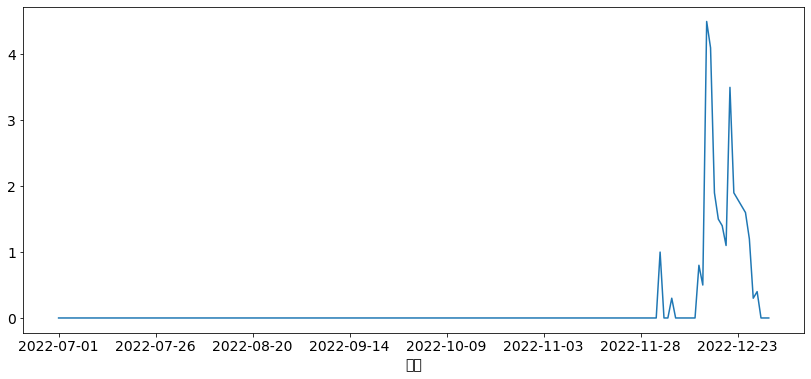

In [46]:
# 확인 결과 3개의 값이 2 이상의 값을 가지며 대부분의 값은 0으로 구성되어 있음을 알 수 있다. 
fig, ax = plt.subplots(figsize=(14, 6))
weather['일 최심적설(cm)'].fillna(0).plot()
weather['일 최심적설(cm)'][weather['일 최심적설(cm)'].fillna(0) > 2]

In [47]:
use_weather['snow'] = weather['일 최심적설(cm)'].fillna(0)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000
rain_hr,0.000000,0.000000,0.000000,0.830000,1.420000
snow,0.000000,0.000000,0.000000,0.000000,0.000000


5. **안개로 인하여 가시거리가 축소되면 공공자전거 이용률이 감소할 것이다.**

    '안개 계속시간(hr)' 값의 존재여부에 따라 안개가 발생하였다고 판단합니다. 
    
    하지만 안개 또한 공공자전거 이용율에 영향을 미칠 것으로 판단되나 본 데이터 세트에서 '안개 계속시간(hr)'이 1개의 값만을 가지고 있으므로 유연한 판단이 어렵습니다. 
    
    따라서 **안개에 따른 영향은 고려하지 않습니다.**

In [48]:
weather[weather['안개 계속시간(hr)'].isna() == False]

,지점,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),...,평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),안개 계속시간(hr)
일시,,,,,,,,,,,,,,,,,,,,,


6. **습도가 높을 경우 공공자전거 이용률이 감소할 것이다.**

    '평균 상대습도(%)' 값으로 습도와 공공자전거 이용률을 분석합니다.

In [49]:
use_weather['humidity_mean'] = weather['평균 상대습도(%)'].fillna(0)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000
rain_hr,0.000000,0.000000,0.000000,0.830000,1.420000
snow,0.000000,0.000000,0.000000,0.000000,0.000000
humidity_mean,83.300000,72.800000,68.600000,71.800000,73.800000


7. **가조시간이 높을 경우 공공자전거 이용률이 증가할 것이다.**

    '가조시간(hr)' 값으로 가조시간에 따른 공공자전거 이용률을 분석합니다.

In [50]:
use_weather['sun_hour'] = weather['가조시간(hr)'].fillna(0)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000
rain_hr,0.000000,0.000000,0.000000,0.830000,1.420000
snow,0.000000,0.000000,0.000000,0.000000,0.000000
humidity_mean,83.300000,72.800000,68.600000,71.800000,73.800000
sun_hour,14.700000,14.700000,14.700000,14.700000,14.700000


8. **평균 풍속이 지나치게 높을 경우 공공자전거 이용률이 감소할 것이다.**

    '평균 풍속(m/s)' 값으로 평균 풍속과 공공자전거 이용률의 상관관계를 분석합니다.

In [51]:
use_weather['wind_speed'] = weather['평균 풍속(m/s)'].fillna(0)
use_weather.head(5).T

일시,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05
temp_mean,10.399457,12.599457,13.099457,13.099457,12.999457
temp_gap,9.000000,9.800000,9.800000,6.200000,6.400000
rain_hr,0.000000,0.000000,0.000000,0.830000,1.420000
snow,0.000000,0.000000,0.000000,0.000000,0.000000
humidity_mean,83.300000,72.800000,68.600000,71.800000,73.800000
sun_hour,14.700000,14.700000,14.700000,14.700000,14.700000
wind_speed,2.100000,1.700000,1.700000,1.800000,1.700000


**생성된 데이터프레임 확인**

위 과정을 통해 생성된 use_weather 데이터프레임을 확인합니다.


In [52]:
print(use_weather.head(5).T)
use_weather.describe().T

일시             2022-07-01  2022-07-02  2022-07-03  2022-07-04  2022-07-05
temp_mean       10.399457   12.599457   13.099457   13.099457   12.999457
temp_gap         9.000000    9.800000    9.800000    6.200000    6.400000
rain_hr          0.000000    0.000000    0.000000    0.830000    1.420000
snow             0.000000    0.000000    0.000000    0.000000    0.000000
humidity_mean   83.300000   72.800000   68.600000   71.800000   73.800000
sun_hour        14.700000   14.700000   14.700000   14.700000   14.700000
wind_speed       2.100000    1.700000    1.700000    1.800000    1.700000


,count,mean,std,min,25%,50%,75%,max
temp_mean,184.0,9.177658,5.986797,0.099457,4.774457,8.599457,12.099457,28.000543
temp_gap,184.0,8.173913,2.761815,2.400000,6.300000,8.050000,10.125000,16.600000
rain_hr,184.0,2.801848,5.100971,0.000000,0.000000,0.000000,3.602500,24.000000
snow,184.0,0.160326,0.616620,0.000000,0.000000,0.000000,0.000000,4.500000
humidity_mean,184.0,69.651630,11.985606,38.900000,61.550000,69.800000,76.600000,98.500000
sun_hour,184.0,11.933152,1.776298,9.600000,10.200000,11.850000,13.600000,14.700000
wind_speed,184.0,2.220652,0.652618,1.300000,1.700000,2.000000,2.600000,4.800000


#### 3.3.2 이상치 조정



이상치를 적절하게 조정하여 지나치게 크거나 동떨어진 데이터가 데이터 분포에 영향을 주는 것을 방지합니다.


**1. 강수시간 이상치 조정**

위, use_weather 데이터프레임의 describe에서 강수시간(rain_hr)은 평균이 3 이하의 값을 가지는데 최댓값은 24임을 확인할 수 있습니다.

평균에서 지나치게 떨어진 값은 분포에 영향을 미칠 수 있음으로 적절한 임계값으로 조정해 주고자 합니다.

최댓값이 평균에 비해 지나치게 큰 값을 가지는지 알아보기 위해 데이터의 분포를 그래프로 표현해보겠습니다. 

Number of days without rain: 54.89
Percentage of values greater than 0 that have a value greater than 10: 21.69


<AxesSubplot:>

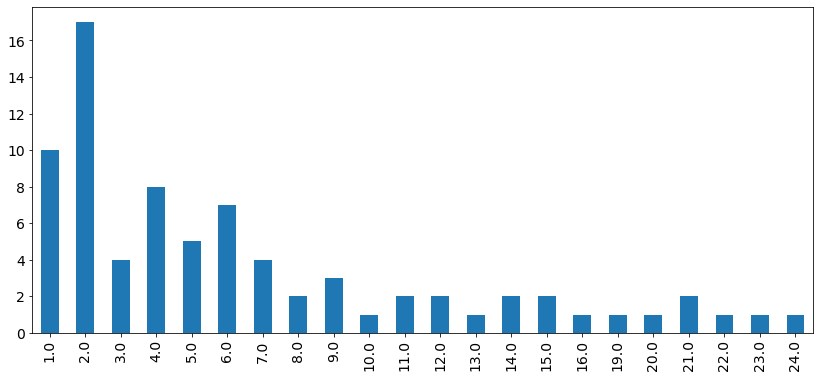

In [53]:
from matplotlib.pyplot import subplots

rain_hr = use_weather['rain_hr']

# 비가 오지 않은 날의 비율
print(f'Number of days without rain: {rain_hr[rain_hr == 0].count() / rain_hr.count() * 100:.2f}')

# 0보다 큰(초과) 값들 중 10 이상의 값을 가지는 비율은 약 20%이다.
print(f'Percentage of values greater than 0 that have a value greater than 10: {rain_hr[rain_hr > 10].count() / rain_hr[rain_hr != 0].count() * 100:.2f}')  # 30

# 강수계속시간을 반올림하여 그래프로 표현하였을 때 
# 10시간 이하의 값이 많으며(90% 이상) 10시간 이상의 값들은 각 시각에 따라 비교적 균등하게 분포되어 있음을 확인할 수 있다.
# 강수계속시간이 0(비가 오지 않았다)인 값의 크기가 비대하여 그래프에 표시하지 않는다.
fig, ax = subplots(figsize=(14, 6))
pd.Series(rain_hr.values.round()).value_counts().sort_index()[1:].plot.bar()

위 분석을 통해 확인할 수 있듯 절반 이상의 값이 0(비가 오지 않았다)을 가지며 10 이상의 강수 계속시간은 비교적 균등한 분포를 이루고 있고 이를 통해 강수 계속시간의 평균이 3 이하의 값을 가지는데 최댓값은 24인 이유는 0(비가 오지 않았다)의 값이 지나치게 많기 때문이라는 것을 확인할 수 있습니다. 

따라서 본 현상을 **이상치** 라고 정의할 수 없고 이상치 조정을 수행할 수 없습니다.

>강수 계속시간이 24시간 이어진다는 점은 의심스러우나 명확한 증거가 없으며 10시간 이후 각 시간에 대한 데이터가 비교적 균등한 점을 고려하여 **이상치**로 정의하지 않았습니다.

#### 3.3.3 CSV로 저장



위 과정을 통해 생성된 use_weather 데이터프레임을 확인한 뒤, csv로 저장합니다.


In [54]:
print(use_weather.head(5).T)
use_weather.describe().T

일시             2022-07-01  2022-07-02  2022-07-03  2022-07-04  2022-07-05
temp_mean       10.399457   12.599457   13.099457   13.099457   12.999457
temp_gap         9.000000    9.800000    9.800000    6.200000    6.400000
rain_hr          0.000000    0.000000    0.000000    0.830000    1.420000
snow             0.000000    0.000000    0.000000    0.000000    0.000000
humidity_mean   83.300000   72.800000   68.600000   71.800000   73.800000
sun_hour        14.700000   14.700000   14.700000   14.700000   14.700000
wind_speed       2.100000    1.700000    1.700000    1.800000    1.700000


,count,mean,std,min,25%,50%,75%,max
temp_mean,184.0,9.177658,5.986797,0.099457,4.774457,8.599457,12.099457,28.000543
temp_gap,184.0,8.173913,2.761815,2.400000,6.300000,8.050000,10.125000,16.600000
rain_hr,184.0,2.801848,5.100971,0.000000,0.000000,0.000000,3.602500,24.000000
snow,184.0,0.160326,0.616620,0.000000,0.000000,0.000000,0.000000,4.500000
humidity_mean,184.0,69.651630,11.985606,38.900000,61.550000,69.800000,76.600000,98.500000
sun_hour,184.0,11.933152,1.776298,9.600000,10.200000,11.850000,13.600000,14.700000
wind_speed,184.0,2.220652,0.652618,1.300000,1.700000,2.000000,2.600000,4.800000


In [55]:
use_weather.to_csv('data/weather.csv')
print('Save to csv: data/weather.csv')

Save to csv: data/weather.csv


#### 결과 비교



전처리가 완료된 "종관기상관측(ASOS)"를 비교해보겠습니다.

아래는 **전처리 전** "종관기상관측(ASOS)"입니다.

In [56]:
pd.read_csv('data/seoul_weather_2022.csv', encoding='cp949').head(3)

,지점,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),...,평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),안개 계속시간(hr)
0,108,2022-01-01,-4.3,-10.2,710.0,2.3,1544,NaN,NaN,NaN,...,0.9,2.7,6.6,10.1,15.1,17.2,1.3,1.8,0.3,NaN
1,108,2022-01-02,-1.3,-5.2,2356.0,3.0,1551,4.17,NaN,NaN,...,0.8,2.7,6.4,10.0,15.0,17.2,1.1,1.6,NaN,NaN
2,108,2022-01-03,-1.9,-8.0,714.0,2.5,1542,4.00,NaN,NaN,...,0.8,2.5,6.2,9.8,14.9,17.2,1.1,1.6,0.0,NaN


아래는 **전처리 후** "종관기상관측(ASOS)" 입니다.

In [57]:
pd.read_csv('data/weather.csv').head(3)

,일시,temp_mean,temp_gap,rain_hr,snow,humidity_mean,sun_hour,wind_speed
0,2022-07-01,10.399457,9.0,0.0,0.0,83.3,14.7,2.1
1,2022-07-02,12.599457,9.8,0.0,0.0,72.8,14.7,1.7
2,2022-07-03,13.099457,9.8,0.0,0.0,68.6,14.7,1.7


## 4. 데이터 분석

문서 상단에서 "최적의 공공자전거 재배치 및 동선 설계"를 수행하기 위해 아래 내용을 데이터 분석 목적으로 설계하였다. 

1. 최적의 재배치 시간은 언제인가.

2. 날씨와 공공자전거 이용률간에 상관관계가 있는가.

3. 최적의 재배치 수량은 몇 개인가.

4. 최적의 재배치 경로는 어떻게 구성할 수 있는가?

전처리된 데이터를 불러와 데이터를 분석하여 위 분석 목적에 대한 결과를 도출해보겠습니다.

### 4.1 최적의 재배치 시간은 언제인가.

재배치 하는 최적의 시간은 **공공자전거를 가장 적게 이용하는 시각** 이라고 생각 할 수 있습니다.

따라서 '대여일시' 열의 값을 통해 24시간 중 가장 많이 대여가 이루어진 시간을 찾고 그래프로 그려봄을 통해 공공자전거 이용율이 가장 작은 시간대를 알아보고 해당 시간을 재배치 시간으로 설정하겠습니다.

[1/6] 2207.csv : reading file...
[2/6] 2208.csv : reading file...
[3/6] 2209.csv : reading file...
[4/6] 2210.csv : reading file...
[5/6] 2211.csv : reading file...
[6/6] 2212.csv : reading file...


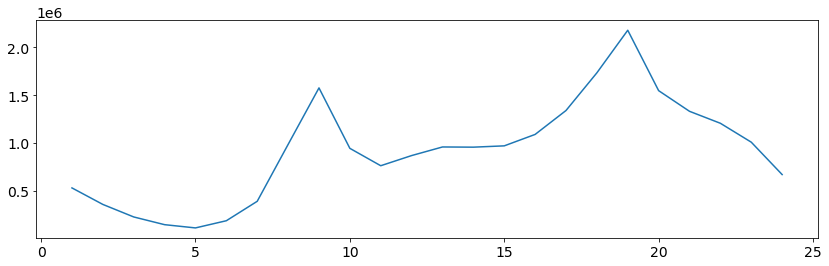

In [58]:
# preprocessing 폴더에 포함된 모든 파일(전체리된 대여이력 정보 csv)들을 하나씩 가져와 시간에 따른 그룹화를 수행한다.
time_count = np.array([0 for __ in range(24)])

file_list_length = len(os.listdir(preprocessing_path))
for file_path, index in csv_iterator(preprocessing_path, start_message='reading file...'):
  time_count += (
      pd.to_datetime(
          pd.read_csv(
              file_path, usecols=['대여일시'])
          .iloc[:, 0]
      ).dt.hour
      .value_counts()
      .sort_index()
      .values
  )

fig, ax = plt.subplots(figsize=(14, 4))
plt.plot([i for i in range(1, 25, 1)], time_count)
plt.show()

위 그래프를 통해 대여가 가장 많이 일어난 시각은 19시이며 가장 적은 대여가 이루어진 시각은 새벽 5시임을 확인할 수 있습니다. 이에 **공공자전거 재배치를 수행하는 최적의 시간은 새벽 5시**라고 결론을 도출 할 수 있습니다.

### 4.2 날씨와 공공자전거 이용률간에 상관관계가 있는가.

"가조시간이 길면 공공자전거 이용률이 증가할 것이다" 와 같이 "종관기상관측(ASOS)" 자료에서 **공공자전거 이용률에 영향을 줄 것으로 예상**되는 변수들을 추출하였습니다. 이에 날씨와 공공자전거 이용률간의 상관관계를 알아보고자 **다중선형회귀모델**을 적합해 보겠습니다. 

다중선형회귀모델 생성을 통한 상관관계 분석은 다음 순서로 진행하겠습니다.

1. 데이터 분할 및 표준화

2. 모델 적합

3. 모델 적합도 평가

4. 결론

In [ ]:
# load linear regression libraries
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 4.2.1 데이터 분할 및 표준화

데이터를 불러온 뒤 날씨 데이터의 표준화를 진행합니다.

날씨 데이터는 각각의 측정 단위와 척도가 다르기에 표준화하여 사용합니다.

표준화 결과, 날씨 데이터는 평균이 0, 분산이 1이며 대여 횟수는 0과 1 사이의 값을 가짐을 확인 할 수 있습니다.

In [ ]:
# Load csv
weather = pd.read_csv('data/weather.csv', index_col=0).loc['2022-07-01':'2022-12-31']
rent = pd.read_csv('data/rent_by_date.csv', index_col=0)

# 날씨 데이터 표준화
# inverse: std_scaler.inverse_transform(data)
std_scaler = StandardScaler()
data = weather
data['rent_count'] = rent.sum(axis=1)

data.describe()

,temp_mean,temp_gap,rain_hr,snow,humidity_mean,sun_hour,wind_speed,rent_count
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,9.177658,8.173913,2.801848,0.160326,69.651630,11.933152,2.220652,120210.885870
std,5.986797,2.761815,5.100971,0.616620,11.985606,1.776298,0.652618,48890.028995
min,0.099457,2.400000,0.000000,0.000000,38.900000,9.600000,1.300000,460.000000
25%,4.774457,6.300000,0.000000,0.000000,61.550000,10.200000,1.700000,82028.500000
50%,8.599457,8.050000,0.000000,0.000000,69.800000,11.850000,2.000000,140100.000000
75%,12.099457,10.125000,3.602500,0.000000,76.600000,13.600000,2.600000,157927.250000
max,28.000543,16.600000,24.000000,4.500000,98.500000,14.700000,4.800000,189134.000000


산점도 행렬을 통해 각 날씨 데이터간의 산관관계를 분석합니다. 

만약 대여횟수와 일정한 패턴, 또는 선형성을 보일 경우 모델에 유의미한 영향을 미칠 가능성이 큽니다. 

하지만 대여횟수가 아닌 변수들 간에 일정한 패턴, 또는 선형성을 보인다면 다중공선성이 유의됨으로 모델 적합시 해당 변수는 제외하는 것을 고려해야 합니다.

/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_96399/1693897211.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, alpha=0.8, ax=ax)


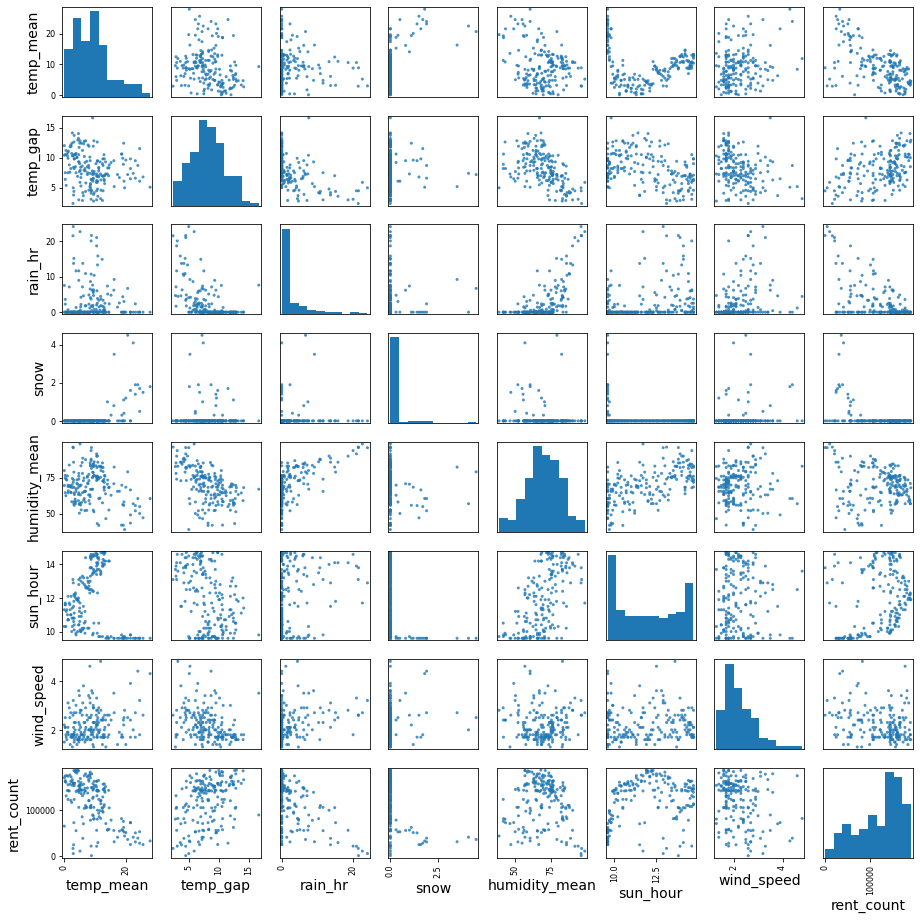

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
pd.plotting.scatter_matrix(data, alpha=0.8, ax=ax)
plt.tight_layout()

평균기온(temp_mean)과 강수시간(rain_hr)가 대여횟수(rent_count)와 선형성을 이루고 있음으로 이 변수들은 공공자전거 이용률 예측에 유의미한 영향을 미칠 가능성이 크다고 판단 할 수 있습니다.

하지만 rain_hr(강수시간)과 humidity_mean(평균습도) 간의 산점도에서 선형성을 보임으로 다중공선성을 의심해볼 수 있습니다.

데이터셋을 학습데이터와 검증데이터로 분할하겠습니다. 랜덤하게 5:5로 분할합니다.

In [ ]:
# split data
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data['rent_count'], test_size=0.5, random_state=42)

#### 4.2.2 모델 적합

학습데이터를 통해 다중선형모델에 적합하여보고 서머리를 출력하여 결과를 분석해보겠습니다.

In [ ]:
# Add Constant on x data
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Generate OLS model
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             rent_count   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     64.69
Date:                Mon, 05 Jun 2023   Prob (F-statistic):           3.69e-31
Time:                        18:11:59   Log-Likelihood:                -1035.8
No. Observations:                  92   AIC:                             2088.
Df Residuals:                      84   BIC:                             2108.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9345.4940   3.06e+04     -0.305

서머리를 통해 다음과 같은 사실을 알 수 있습니다.

1. 본 모델은 데이터를 84% 정도 설명할 수 있다. 

2. F 통계량의 p값을 통해 본 모델이 유의함을 확인 할 수 있다.

3. 평균기온과 강수시간, 적설량은 대여이력과 음의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 증가한다.

4. 일교차와 평균습도, 가조시간과 풍속은 대여이력과 양의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 감소한다.

5. 각 변수의 p값을 통해 적설량과 평균습도는 모델에 유의하지 않다.

위 모델을 통해 예측을 진행해보겠습니다.

MSE: 530976418.6015
RMSE: 23042.9256


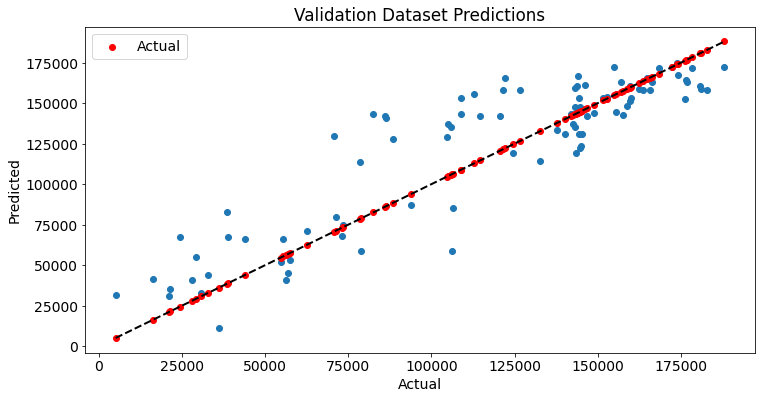

In [ ]:
# Predict test data
y_pred = model.predict(x_test)

# mse, rmse
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

# Show prediction graph
plt.scatter(y_test, y_pred)
plt.scatter(y_test, y_test, color='red', label='Actual')  # Mark actual values with red dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation Dataset Predictions')
plt.legend()
plt.show()

붉은색 점은 실제 데이터이고 푸른색 점은 모델을 통해 예측된 데이터입니다. 이를 통해 모델이 데이터를 비교적 잘 적합하나 오차가 있음을 확인할 수 있습니다.

이에 모델에 있어 유의하지 않았던 '적설량'과 '상대습도' 변수를 제외하여 모델을 생성한 뒤 서머리를 출력하여 결과를 분석해보겠습니다.

In [ ]:
x_train2 = x_train.drop(columns=['humidity_mean', 'snow'])
model2 = sm.OLS(y_train, x_train2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             rent_count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     92.18
Date:                Mon, 05 Jun 2023   Prob (F-statistic):           4.89e-33
Time:                        18:11:59   Log-Likelihood:                -1036.1
No. Observations:                  92   AIC:                             2084.
Df Residuals:                      86   BIC:                             2099.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5237.5391   2.48e+04     -0.211      0.8

서머리를 통해 다음과 같은 사실을 알 수 있습니다.

1. 본 모델은 데이터를 84% 정도 설명할 수 있다. 

2. F 통계량의 p값을 통해 본 모델이 유의함을 확인 할 수 있다.

3. 평균기온과 강수시간은 대여이력과 음의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 증가한다.

4. 일교차와 가조시간, 풍속은 대여이력과 양의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 감소한다.

위 모델을 통해 예측을 진행해보겠습니다.

MSE: 520215097.3277
RMSE: 22808.2243


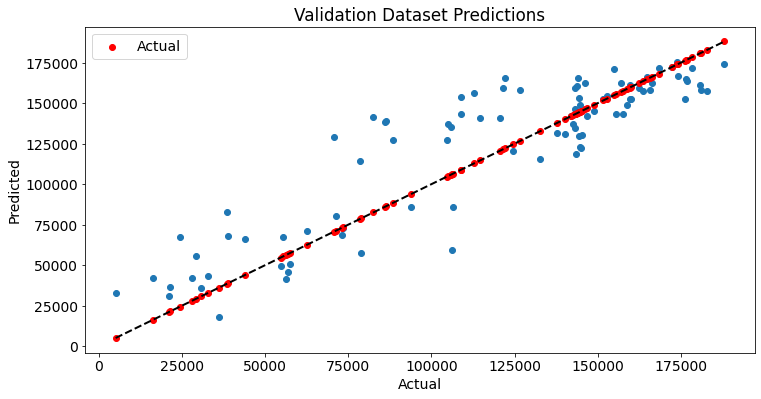

In [ ]:
# Predict test data for model2
x_test2 = x_test.drop(columns=['humidity_mean', 'snow'])
y_pred2 = model2.predict(x_test2)

# mse, rmse
mse = mean_squared_error(y_test, y_pred2)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

# Show prediction graph
plt.scatter(y_test, y_pred2)
plt.scatter(y_test, y_test, color='red', label='Actual')  # Mark actual values with red dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation Dataset Predictions')
plt.legend()
plt.show()

#### 4.2.3 모델 적합도 평가

생성된 두 모델을 비교하여 더 성능이 좋은 모델을 결정해보겠습니다.

**결정계수에 따른 비교**

모든 변수를 포함한 모델과 일부 변수만을 포함한 모델 모두 84%의 설명력을 가졌습니다. 이에 결정계수 값을 통해 두 모델을 비교 할 수는 없습니다.

**RMSE에 따른 비교**

모든 변수를 포함한 모델의 RMSE 값은 23042.9256 이고 일부 변수만 포함한 두 번째 모델의 RMSE 값인 22808.2243 입니다.
이를 통해 일부 변수만을 포함한 두 번째 모델이 더 작은 오차를 가짐으로 더 우수한 성능을 보임을 확인할 수 있습니다.

**AIC, BIC에 따른 비교**

모든 변수를 포함한 모델의 AIC값은 2088 이고 일부 변수만 포함한 두 번째 모델의 AIC값은 2108 입니다.
모든 변수를 포함한 모델의 BIC값은 2084 이고 일부 변수만 포함한 두 번째 모델의 BIC값은 2099 입니다.
AIC와 BIC 모두 일부 변수만 포함한 모델이 더 낮은 값을 가짐으로 일부 변수만 포함한 모델이 더 우수한 성능을 보임을 확인 할 수 있습니다.

이에 종합적으로 고려해 보았을 때 **일부 변수만 포함한 두 번째 모델이 더 우수한 모델**임을 확인 할 수 있습니다.

#### 4.2.4 결론

날씨와 공공자전거 이용률 간의 상관관계 분석을 통해 다음 사실을 확인 할 수 있습니다. 

1. 본 모델은 데이터의 84% 를 설명할 수 있다.

2. 평균기온과 강수시간은 대여이력과 음의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 증가한다.

3. 일교차와 가조시간, 풍속은 대여이력과 양의 상관관계를 가진다. 즉 이 요소들이 감소할 경우 대여이력은 감소한다.

4. 적설량과 평균습도는 공공자전거 이용률에 큰 영향을 미치지 못한다.

또한 아래와 같이 모델을 이용하여 내일 기상 예측 정보를 통해 예상 대여량을 구할 수 있습니다.

In [ ]:
use_weather_columns = ['temp_mean', 'temp_gap', 'rain_hr', 'sun_hour', 'wind_speed']

today_rent = int(data.loc['2022-07-04'].loc['rent_count'])
tomorrow_weather = data.loc[['2022-07-05']].loc[:,use_weather_columns]

print(f'Today rent count: {today_rent}')
tomorrow_weather

Today rent count: 149019


,temp_mean,temp_gap,rain_hr,sun_hour,wind_speed
일시,,,,,
2022-07-05,12.999457,6.4,1.42,14.7,1.7


In [ ]:
# Add Constant
use_weather_columns.insert(0, 'const')
tomorrow_weather[use_weather_columns[0]] = 1.0
tomorrow_weather = tomorrow_weather[use_weather_columns]

# Predict
pred_rent_count = model2.predict(tomorrow_weather)
tomorrow_pred_rent = round(pred_rent_count.values[0])
increase_rate = tomorrow_pred_rent / today_rent
status = '증가' if increase_rate >= 1 else '감소'
print(f'오늘 날씨를 통해 예측된 내일 공공자전거 대여횟수는 {tomorrow_pred_rent}회로 {round((1- increase_rate)* -100, 2)}% {status}할 것으로 예상됩니다.')

오늘 날씨를 통해 예측된 내일 공공자전거 대여횟수는 142296회로 -4.51% 감소할 것으로 예상됩니다.


### 4.3 최적의 재배치 수량은 몇 개인가.

최적의 공공자전거 재배치 수량은 (각 대여소의 회수율) * (날씨에 따른 사용률 증감)을 통해 도출해보겠습니다.

2022-09-07 에 JC

In [59]:
# def daterange(start_date, end_date):
#     for n in range(int((end_date - start_date).days)):
#         yield start_date + timedelta(n)


# def get_date_list(start_date, end_date):
#     date_list = []
#     for single_date in daterange(start_date, end_date):
#         date_list.append(single_date.strftime("%Y-%m-%d"))
#     return date_list


# def create_station_with_date(start_date, end_date):
#     return (pd.DataFrame(
#         columns=list(pd.read_csv('data/대여소 정보.csv', index_col=0).index),
#         index=get_date_list(start_date, end_date))
#         .pipe(lambda df: df.fillna(0))
#         .pipe(lambda df: df.astype(np.int16)))

# def apply_by_station(df: pd.DataFrame, save_df:pd.DataFrame, group_date: datetime.date):
#     date, id = df.columns
#     cur_date = str(group_date)
#     df = df.groupby([id]).count()
#     save_df.loc[cur_date] = save_df.loc[cur_date].add(df[date], fill_value=0)
#     return save_df


# # 각 날짜에 따른 대여소의 대여횟수와 반납횟수를 정리할 빈 데이터프레임을 생성한다.
# rent_by_date = create_station_with_date(date(2022, 7, 1), date(2023, 1, 1))
# return_by_date = create_station_with_date(date(2022, 7, 1), date(2023, 1, 1))

# # 각각의 파일을 전처리된 대여이력 파일을 불러와 날짜에 따른 대여횟수와 반납횟수를 파악해 정리한다. 
# for file_path, index in csv_iterator(preprocessing_path, start_message=f'Measuring recovery rate...'):
#     # load data
#     df = pd.read_csv(file_path, usecols=['대여일시', '반납일시', '대여대여소ID', '반납대여소ID'])
#     df['대여일시'] = pd.to_datetime(df['대여일시'])
#     df['반납일시'] = pd.to_datetime(df['반납일시'])

#     # 반납일시의 경우 해를 넘겨 2023-01-01 값이 존재함으로 제거한다.
#     if (df['반납일시'].tail(1).dt.date.values[0] == datetime(2023, 1, 1).date()):
#         df = df[df['반납일시'].dt.date <= datetime(2022, 12, 31).date()]

#     # 일시와 대여소를 기준으로 자전거 개수를 그룹화한다.
#     (df[['대여일시', '대여대여소ID']].groupby([df['대여일시'].dt.date]).apply(lambda df: apply_by_station(df, rent_by_date, df.name)))
#     (df[['반납일시', '반납대여소ID']].groupby([df['반납일시'].dt.date]).apply(lambda df: apply_by_station(df, return_by_date, df.name)))

# # 대여 횟수를 CSV로 저장한다. 
# print(f'Saving to csv: data/rent_by_date.csv')
# rent_by_date.to_csv('data/rent_by_date.csv')

# # 증감을 CSV로 저장한다.
# print(f'Saving to csv: data/recovery.csv')
# recovery = return_by_date.sub(rent_by_date, fill_value=0)
# recovery.to_csv('data/recovery.csv')

대여 횟수는 다음과 같이 구성됩니다.

In [60]:
# rent_by_date.tail()

회수 대수는 다음과 같이 구성됩니다.

`반납개수 - 대여대수` 임으로 recovery만큼 자전거를 수거해야 합니다. 예를 들어 6이면 6개만큼 더 반납한 것임으로 6개를 수거해야하고, -5이면 5개만큼 더 대여한것임으로 5개를 더 배치해야 합니다.

In [61]:
# recovery.tail()